# You Only Look Once

> YOLO는 격자 그리드로 나누어 한번에 클래스를 판단하고 이를 통합하여 최종 객체를 구분
기존의 방법들과 달리 object detection을 이미지 픽셀 좌표에 대응되는 bounding box를 찾음
그리고 이에 대한 class 확률을 구하는 single regression problem으로 해결

* input image를 s X s grid로 분할(해당 셀에 물체의 중심 위치로 가정)
* cell은 B개의 bounding box와 각 객체 존재에 대한 confidence score로 구성
* cell은 C개의 클래스 확률로 구성 박스
* 결과적으로 마지막 prediction layer는 s X s X (B * 5 + C) 사이즈가 됨

In [27]:
import cv2 as cv2
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt
%matplotlib inline


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [19]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
nmsThreshold = 0.4  # Non-maximum suppression threshold
inpWidth = 416  # Width of network's input image 고정된 사이즈 사용 (필요시 resize 진행)
inpHeight = 416  # Height of network's input image

# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg"  # 학습시에 필요한 parameter
modelWeights = "yolov3.weights"

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [20]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box


def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    # Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(
        label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(
        1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top),
               cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression


def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left,
                 top, left + width, top + height)

In [21]:
cap = cv.VideoCapture('dog.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv.dnn.blobFromImage(
    frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)
net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

array([[[ 50,  58,  56],
        [ 51,  59,  57],
        [ 53,  61,  59],
        ...,
        [ 31, 102, 119],
        [ 39,  53,  77],
        [ 45,  59,  83]],

       [[ 51,  59,  57],
        [ 51,  59,  57],
        [ 52,  60,  58],
        ...,
        [ 21,  86, 104],
        [ 41,  54,  73],
        [ 46,  59,  78]],

       [[ 51,  59,  56],
        [ 51,  59,  56],
        [ 52,  60,  57],
        ...,
        [ 10,  64,  83],
        [ 47,  58,  67],
        [ 42,  53,  62]],

       ...,

       [[179, 167, 160],
        [179, 167, 160],
        [183, 170, 163],
        ...,
        [ 64,  63,  80],
        [ 36,  39,  52],
        [ 48,  51,  64]],

       [[181, 170, 161],
        [180, 169, 160],
        [176, 165, 156],
        ...,
        [ 61,  61,  77],
        [ 37,  41,  54],
        [ 52,  56,  69]],

       [[177, 166, 157],
        [178, 167, 158],
        [173, 162, 153],
        ...,
        [ 62,  62,  78],
        [ 33,  37,  50],
        [ 35,  39,  52]]

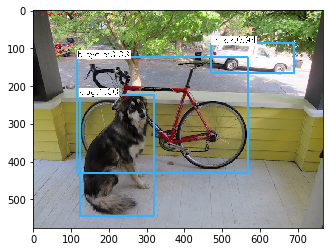

In [22]:
cv.imwrite("out.jpg", frame)
img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.imshow(img)

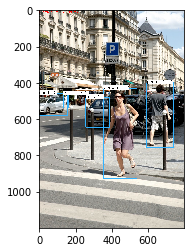

In [23]:
cap = cv.VideoCapture('road.jpg')

hasFrame, frame = cap.read()

blob = cv.dnn.blobFromImage(
    frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)
net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

cv.imwrite("out2.jpg", frame)
img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.imshow(img)

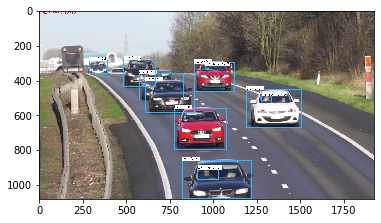

In [24]:
cap = cv.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

blob = cv.dnn.blobFromImage(
    frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)
net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

cv.imwrite("out3.jpg", frame)
img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.imshow(img)

## 첫번째 layer만 사용하여 검출(yolo_82)

### layer 확인

In [25]:
# yolo layer 82
cap = cv2.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

y_82 = net.forward("yolo_82")
print(y_82.shape)

(507, 85)


### layer 적용, 검출

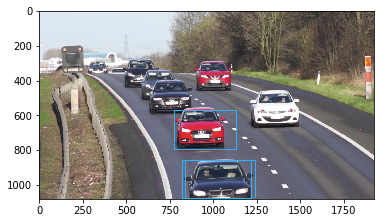

In [29]:
yolo = net.forward("yolo_82")
frame = cv2.imread("cars.jpg")
frameHeight = frame.shape[0]
frameWidth = frame.shape[1]

for i in range(len(yolo)):
    detection = yolo[i]
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.01:
        center_x = int(detection[0] * frameWidth)
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        cv2.rectangle(frame, (left, top), (left+width,
                                           top+height), (255, 178, 50), 3)
imshow("", frame)

## 검출지역 확인

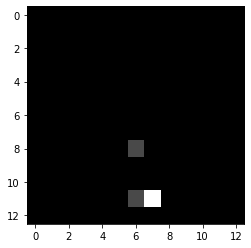

In [31]:
cells = []
for i in range(len(yolo))     :   
    detection = yolo[i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    cells.append(classId)
    
cells = np.array(cells)
cells = cells.reshape(13,13,3)
img = cells[:,:,0]*30
imshow("", img)

In [33]:
frame = cv2.imread("dog.jpg")
frameHeight = frame.shape[0]
frameWidth = frame.shape[1]

# blob (image, scalefactor, size, mean, swapRB)
blob = cv2.dnn.blobFromImage(
    frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)
# N: number of images in the batch
# H: height of the image
# W: width of the image
# C: number of channels of the image (ex: 3 for RGB, 1 for grayscale...)
print(blob.shape)

(1, 3, 416, 416)


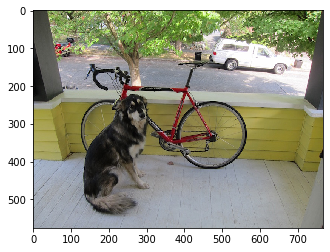

In [34]:
net.setInput(blob)
yolo = net.forward("yolo_106")

for i in range(len(yolo)):
    detection = yolo[i]
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.01:
        center_x = int(detection[0] * frameWidth)
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        cv2.rectangle(frame, (left, top), (left+width,
                                           top+height), (255, 178, 50), 3) 

imshow("", frame)

In [47]:
import math
cells = []
for i in range(len(yolo)):
    detection = yolo[i]
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.01:
        cells.append(classId)
    else:
        cells.append(0)
    

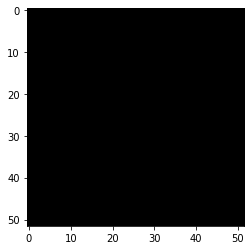

In [48]:
cells = np.array(cells)

s = int(math.sqrt(len(yolo)/3))

cells = cells.reshape(s, s, 3)

img = cells[:, :, 0]*30

imshow('', img)